# Explainable AI for Object Detection with YOLOv8 and EigenCAM

In [2]:
import os
from zipfile import ZipFile

import cv2
import datature
import matplotlib.pyplot as plt
import numpy as np
import wget
from ultralytics import YOLO
from yolov8_cam.eigen_cam import EigenCAM
from yolov8_cam.utils.image import show_cam_on_image

### Lettura e preprocessing dell'immagine

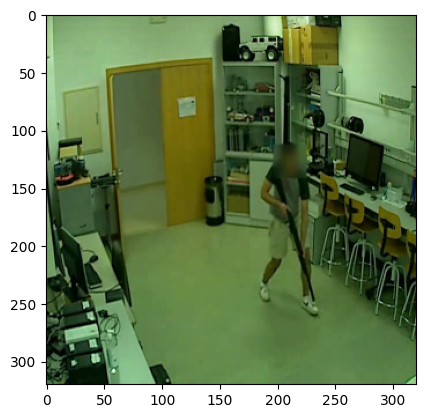

In [3]:
model = YOLO("/Users/andreavisi/Desktop/PYTHON/Computer Vision e Deep Learning 2024/PROGETTO/train_w_YOLOv9c_2/weights/best.pt")

# Caricamento e ridimensionamento dell'immagine
img = cv2.imread('/Users/andreavisi/Desktop/PYTHON/Computer Vision e Deep Learning 2024/PROGETTO/Gun_Action_Recognition_Dataset/test/images/Machine_Gun_PCW4_C1_P1_V1_HB_1_frame_0150.jpg')
img = cv2.resize(img, (320, 320))

# Creazione di una copia in formato RGB
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Normalizzazione dell'immagine
img = np.float32(rgb_img) / 255

# Visualizzazione dell'immagine
plt.imshow(rgb_img)
plt.show()

### Seleziona il layer target per l'estrazione delle caratteristiche

Le diverse architetture dei modelli tendono a utilizzare diverse attivazioni dei livelli, quindi sarà necessario adattarle di conseguenza se si sta utilizzando un modello personalizzato.

In [4]:
print(model.model.model)

Sequential(
  (0): Conv(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (1): Conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (2): RepNCSPELAN4(
    (cv1): Conv(
      (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (cv2): Sequential(
      (0): RepCSP(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
       

In [5]:
target_layers = [model.model.model[-4]]

In [6]:
print(target_layers)

[ADown(
  (cv1): Conv(
    (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    (act): SiLU(inplace=True)
  )
)]



0: 480x480 1 Machine_Gun, 379.4ms
Speed: 1.7ms preprocess, 379.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 480)
principal component 1


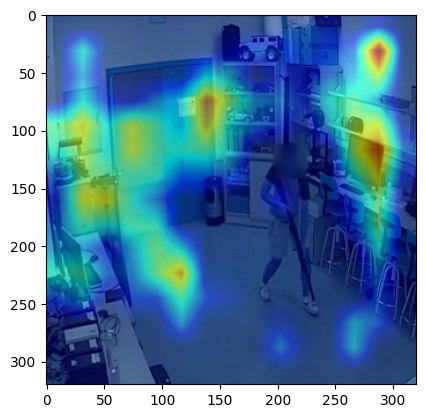

principal component 2


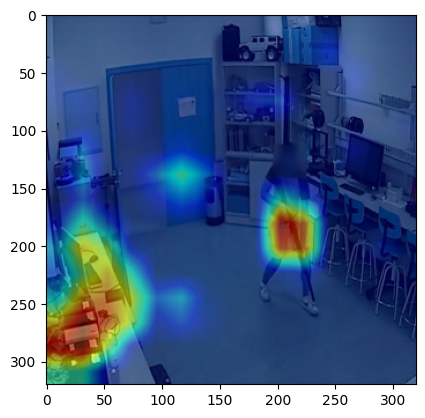

principal component 3


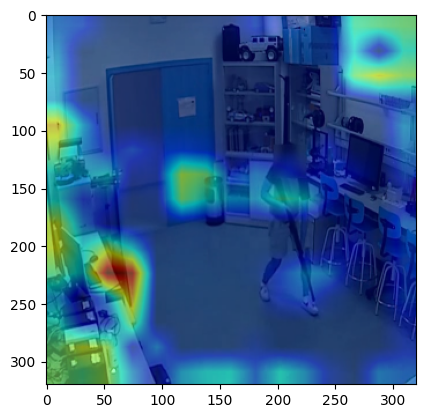

In [8]:
# Seleziona quali componenti principali vuoi evidenziare, zero-indexed
principal_comp = [0,1,2]
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(
    rgb_img,
    eigen_smooth=True,
    principal_comp=principal_comp,
)

for i in range(grayscale_cam.shape[3]):
    cam_image = show_cam_on_image(img, grayscale_cam[0,:,:,i], use_rgb=True)
    print(f"principal component {principal_comp[i]+1}")
    plt.imshow(cam_image)
    plt.show()

In [ ]:
# Seleziona i componenti principali da 1 a 128
numeri = list(range(0, 127))

# Inizializza EigenCAM
cam = EigenCAM(model, target_layers, task='od')
grayscale_cam = cam(
    rgb_img,
    eigen_smooth=True,
    principal_comp=numeri,
)

# Inizializza VideoWriter
height, width, _ = img.shape
video_path = 'output_video_YOLOv9c_2.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

for i in range(grayscale_cam.shape[3]):
    cam_image = show_cam_on_image(img, grayscale_cam[0,:,:,i], use_rgb=True)
    print(f"principal component {numeri[i]+1}")
    
    # Converti l'immagine in formato compatibile con OpenCV
    cam_image = (cam_image * 255).astype(np.uint8)
    
    # Aggiungi testo all'immagine
    cv2.putText(cam_image, f"PC {numeri[i]+1}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    # Aggiungi l'immagine al video
    out.write(cam_image)
    
    # Mostra l'immagine (opzionale)
    plt.imshow(cam_image)
    plt.show()

# Rilascia il VideoWriter
out.release()
print(f"Video salvato in {video_path}")
